# TimeSeries RL Agent Tuning Tutorial

Welcome to the RLTimeSeriesAgent tuning tutorial! This notebook demonstrates how to use the ModelTuner to find the optimal hyperparameters for your TimeSeries RL Agent. The tuner allows you to explore different configurations and automatically train multiple models with varying parameters to find the best performing combination.

This tutorial is divided into three main parts:

1. Setting Up and Configuring the Tuner
2. Running the Hyperparameter Search
3. Training the Final Model with Best Parameters

Let's get started!

## Installation

First, let's install the required packages:

In [1]:
!pip install timeseries-agent --quiet
!pip install lightning torch --quiet

## Part 1: Setting Up and Configuring the Tuner

### 1.1 Import Libraries

Let's start by importing all necessary libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)  # sets seeds for numpy, torch and python.random

from timeseries_agent import RLTimeSeriesDataset, PolicyGradientAgent
from timeseries_agent.tuning.tuner import ModelTuner

Seed set to 42


### 1.2 Create Sample Data

We'll create a sample dataset with different patterns to test our models:

In [3]:
# Create patterns
data1 = np.array([1, 2, 2] * 5)
data2 = np.array([1, 0, 0] * 5)
data3 = np.array([0, -2, -2, 0] * 5)
data4 = np.array([np.sin(x) for x in np.linspace(0, 8 * np.pi, 20)])

# Concatenate the data
value_col = np.concatenate([data1, data2, data3, data4] * 3)

# Create second feature
feature2_col = np.roll(value_col, 1) + np.random.randn(len(value_col)) * 0.1
feature2_col[0] = value_col[0]

# Create DataFrame
data_df = pd.DataFrame({'value': value_col, 'feature2': feature2_col})

print("Sample DataFrame Head:")
print(data_df.head())
print(f"\nDataFrame Shape: {data_df.shape}")

Sample DataFrame Head:
   value  feature2
0    1.0  1.000000
1    2.0  0.986174
2    2.0  2.064769
3    1.0  2.152303
4    2.0  0.976585

DataFrame Shape: (210, 2)


### 1.3 Define Hyperparameter Search Space

Define the ranges of hyperparameters we want to explore:

In [4]:
# Hyperparameter ranges to test
param_ranges = {
    'learning_rate': [0.001, 0.0005],           # Different learning rates
    'lookback': [5, 7],                         # Different lookback periods
    'hidden_layers': [
        [100, 100, 10],                         # Original architecture
        [200, 100, 50],                         # Wider architecture
    ],
    'epsilon_start': [1.0, 0.9],               # Different exploration start rates
    'epsilon_end': [0.01, 0.05],               # Different exploration end rates
    'epsilon_decay_epochs_rate': [0.4, 0.6],   # Different decay rates 
}

# Base parameters that will be the same for all models
base_params = {
    'normalize_state': True,            # Normalize input states
    'eval_noise_factor': 0.1,           # Add noise during evaluation
    'num_training_epochs': 10,          # Number of training epochs
}

print("\nHyperparameter Search Space:")
for param, values in param_ranges.items():
    print(f"{param}: {values}")

print("\nBase Parameters:")
for param, value in base_params.items():
    print(f"{param}: {value}")


Hyperparameter Search Space:
learning_rate: [0.001, 0.0005]
lookback: [5, 7]
hidden_layers: [[100, 100, 10], [200, 100, 50]]
epsilon_start: [1.0, 0.9]
epsilon_end: [0.01, 0.05]
epsilon_decay_epochs_rate: [0.4, 0.6]

Base Parameters:
normalize_state: True
eval_noise_factor: 0.1
num_training_epochs: 10


## Part 2: Running the Hyperparameter Search

### 2.1 Initialize and Run the Tuner

Create the ModelTuner and start the hyperparameter search:

In [5]:
# Create tuner instance
tuner = ModelTuner(
    data_df=data_df,
    base_log_dir="logs",
    target_column="value",
)

# Train models with different hyperparameter combinations
print("\nStarting hyperparameter search...")
results = tuner.train(
    param_ranges=param_ranges,
    num_epochs=base_params['num_training_epochs'],
    base_params=base_params,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\dat


Starting hyperparameter search...

Training model 1/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=1, train_reward=0.529, train_loss=-0.106, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=1, train_reward=0.529, train_loss=-0.106, epsilon=0.010]

c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.36274510622024536
   val_pass_percentage       68.13725280761719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 2/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, v_num=1, train_reward=0.667, train_loss=-0.0366, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.2549019753932953
   val_pass_percentage       62.74509811401367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 3/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, v_num=1, train_reward=0.627, train_loss=-0.346, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.30392158031463623
   val_pass_percentage       65.19607543945312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 4/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=1, train_reward=0.529, train_loss=-0.0728, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.30392158031463623
   val_pass_percentage       65.19607543945312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 5/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.98it/s, v_num=1, train_reward=0.500, train_loss=-0.0696, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4117647111415863
   val_pass_percentage       70.5882339477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 6/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=1, train_reward=0.529, train_loss=-0.0796, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.44117647409439087
   val_pass_percentage       72.05882263183594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 7/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=1, train_reward=0.490, train_loss=-0.252, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.38235294818878174
   val_pass_percentage       69.11764526367188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 8/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=1, train_reward=0.490, train_loss=-0.203, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.38235294818878174
   val_pass_percentage       69.11764526367188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 9/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, v_num=1, train_reward=0.461, train_loss=-0.157, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.37254902720451355
   val_pass_percentage       68.62744903564453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 10/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=1, train_reward=0.451, train_loss=-0.048, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4215686321258545
   val_pass_percentage       71.07843017578125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 11/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=1, train_reward=0.451, train_loss=-0.268, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4117647111415863
   val_pass_percentage       70.5882339477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 12/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=1, train_reward=0.412, train_loss=-0.564, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.46078431606292725
   val_pass_percentage       73.03921508789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 13/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, v_num=1, train_reward=0.490, train_loss=-0.16, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4117647111415863
   val_pass_percentage       70.5882339477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 14/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=1, train_reward=0.529, train_loss=-0.104, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward          0.343137264251709
   val_pass_percentage       67.1568603515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 15/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=1, train_reward=0.382, train_loss=-0.257, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4117647111415863
   val_pass_percentage       70.5882339477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 16/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=1, train_reward=0.373, train_loss=-0.459, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward          0.343137264251709
   val_pass_percentage       67.1568603515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 17/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=1, train_reward=0.545, train_loss=-0.083, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3663366436958313
   val_pass_percentage       68.31683349609375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 18/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=1, train_reward=0.554, train_loss=-0.0674, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.40594056248664856
   val_pass_percentage       70.29702758789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 19/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, v_num=1, train_reward=0.475, train_loss=-0.173, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3861386179924011
   val_pass_percentage       69.30693054199219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 20/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, v_num=1, train_reward=0.485, train_loss=-0.272, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.39603960514068604
   val_pass_percentage       69.8019790649414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 21/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, v_num=1, train_reward=0.495, train_loss=-0.0682, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3564356565475464
   val_pass_percentage       67.82178497314453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 22/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}



  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, v_num=1, train_reward=0.495, train_loss=-0.0633, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4356435537338257
   val_pass_percentage       71.78218078613281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 23/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, v_num=1, train_reward=0.396, train_loss=-0.275, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.5148515105247498
   val_pass_percentage       75.7425765991211
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 24/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, v_num=1, train_reward=0.426, train_loss=-0.426, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3366336524486542
   val_pass_percentage       66.83168029785156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 25/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, v_num=1, train_reward=0.545, train_loss=-0.106, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4653465449810028
   val_pass_percentage       73.26732635498047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 26/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=1, train_reward=0.505, train_loss=-0.0598, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.40594056248664856
   val_pass_percentage       70.29702758789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 27/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=1, train_reward=0.386, train_loss=-0.404, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.39603960514068604
   val_pass_percentage       69.8019790649414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 28/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=1, train_reward=0.426, train_loss=-0.40, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3861386179924011
   val_pass_percentage       69.30693054199219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 29/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=1, train_reward=0.505, train_loss=-0.0253, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4752475321292877
   val_pass_percentage       73.76237487792969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 30/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, v_num=1, train_reward=0.386, train_loss=-0.0199, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4752475321292877
   val_pass_percentage       73.76237487792969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 31/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, v_num=1, train_reward=0.554, train_loss=-0.155, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3564356565475464
   val_pass_percentage       67.82178497314453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 32/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=1, train_reward=0.218, train_loss=-0.361, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.6138613820075989
   val_pass_percentage       80.69306945800781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 33/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=1, train_reward=0.520, train_loss=-0.0642, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.3235294222831726
   val_pass_percentage       66.17646789550781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 34/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=1, train_reward=0.686, train_loss=0.0147, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.2450980395078659
   val_pass_percentage       62.25490188598633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 35/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=1, train_reward=0.500, train_loss=-0.082, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.3333333432674408
   val_pass_percentage       66.66666412353516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 36/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=1, train_reward=0.461, train_loss=-0.136, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.36274510622024536
   val_pass_percentage       68.13725280761719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 37/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=1, train_reward=0.647, train_loss=0.0226, epsilon=0.010]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.2549019753932953
   val_pass_percentage       62.74509811401367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 38/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, v_num=1, train_reward=0.441, train_loss=-0.0748, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4117647111415863
   val_pass_percentage       70.5882339477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 39/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, v_num=1, train_reward=0.627, train_loss=-0.169, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.20588235557079315
   val_pass_percentage       60.29411697387695
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 40/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=1, train_reward=0.588, train_loss=-0.175, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.2647058963775635
   val_pass_percentage      63.235294342041016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 41/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, v_num=1, train_reward=0.431, train_loss=0.00405, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.46078431606292725
   val_pass_percentage       73.03921508789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 42/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, v_num=1, train_reward=0.471, train_loss=-0.0637, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4117647111415863
   val_pass_percentage       70.5882339477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 43/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, v_num=1, train_reward=0.539, train_loss=-0.0161, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.3921568691730499
   val_pass_percentage       69.60784149169922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 44/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=1, train_reward=0.451, train_loss=-0.424, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.36274510622024536
   val_pass_percentage       68.13725280761719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 45/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=1, train_reward=0.490, train_loss=-0.0849, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.3921568691730499
   val_pass_percentage       69.60784149169922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 46/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=1, train_reward=0.500, train_loss=-0.0727, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.4019607901573181
   val_pass_percentage       70.09803771972656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 47/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=1, train_reward=0.480, train_loss=-0.11, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.38235294818878174
   val_pass_percentage       69.11764526367188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 48/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, v_num=1, train_reward=0.608, train_loss=-0.569, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.27450981736183167
   val_pass_percentage       63.72549057006836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 49/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, v_num=1, train_reward=0.545, train_loss=-0.0507, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.39603960514068604
   val_pass_percentage       69.8019790649414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 50/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=1, train_reward=0.505, train_loss=-0.107, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.41584157943725586
   val_pass_percentage       70.79207611083984
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 51/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, v_num=1, train_reward=0.505, train_loss=-0.0725, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.30693069100379944
   val_pass_percentage       65.3465347290039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 52/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, v_num=1, train_reward=0.485, train_loss=-0.156, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4356435537338257
   val_pass_percentage       71.78218078613281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 53/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=1, train_reward=0.525, train_loss=-0.0867, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3762376010417938
   val_pass_percentage       68.81188201904297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 54/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=1, train_reward=0.515, train_loss=-0.118, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.40594056248664856
   val_pass_percentage       70.29702758789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 55/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, v_num=1, train_reward=0.455, train_loss=-0.258, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4356435537338257
   val_pass_percentage       71.78218078613281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 56/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, v_num=1, train_reward=0.406, train_loss=-0.129, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.40594056248664856
   val_pass_percentage       70.29702758789062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 57/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s, v_num=1, train_reward=0.535, train_loss=-0.133, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3465346395969391
   val_pass_percentage       67.32673645019531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 58/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, v_num=1, train_reward=0.505, train_loss=-0.07, epsilon=0.010]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4356435537338257
   val_pass_percentage       71.78218078613281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 59/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=1, train_reward=0.436, train_loss=-0.249, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.4356435537338257
   val_pass_percentage       71.78218078613281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 60/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.92it/s, v_num=1, train_reward=0.455, train_loss=-0.129, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3663366436958313
   val_pass_percentage       68.31683349609375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 61/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, v_num=1, train_reward=0.644, train_loss=-0.01, epsilon=0.010]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.3762376010417938
   val_pass_percentage       68.81188201904297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 62/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, v_num=1, train_reward=0.554, train_loss=-0.0756, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.42574256658554077
   val_pass_percentage       71.2871322631836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 63/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, v_num=1, train_reward=0.554, train_loss=-0.121, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.2673267424106598
   val_pass_percentage      63.366336822509766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 64/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=1, train_reward=0.614, train_loss=-0.336, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.20792078971862793
   val_pass_percentage       60.39603805541992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Tuning results saved to: c:\Users\Collins P. Ohagwu\Desktop\pypi_projects\timeseries_agent\examples\logs\tuning_results_v1.csv


### 2.2 Analyze Tuning Results

Let's examine the results of our hyperparameter search:

In [6]:
print("\nTuning Results (sorted by validation reward):")
print(results)

# Get best performing model details
best_model = results.iloc[0]
print("\nBest Model Configuration:")
for param, value in best_model.items():
    print(f"{param}: {value}")

print(f"\nBest model checkpoint saved at: {best_model['model_dir']}")


Tuning Results (sorted by validation reward):
    learning_rate  lookback   hidden_layers  epsilon_start  epsilon_end  \
31         0.0010         7  [200, 100, 50]            0.9         0.05   
22         0.0010         7  [100, 100, 10]            0.9         0.05   
29         0.0010         7  [200, 100, 50]            0.9         0.01   
28         0.0010         7  [200, 100, 50]            0.9         0.01   
24         0.0010         7  [200, 100, 50]            1.0         0.01   
..            ...       ...             ...            ...          ...   
1          0.0010         5  [100, 100, 10]            1.0         0.01   
36         0.0005         5  [100, 100, 10]            0.9         0.01   
33         0.0005         5  [100, 100, 10]            1.0         0.01   
63         0.0005         7  [200, 100, 50]            0.9         0.05   
38         0.0005         5  [100, 100, 10]            0.9         0.05   

    epsilon_decay_epochs_rate  val_avg_reward  val_p

## Part 3: Training Final Model with Best Parameters

### 3.1 Setup Final Training

Extract and prepare the best parameters for final training:

In [7]:
# Extract best hyperparameters
best_params = {
    'learning_rate': best_model['learning_rate'],
    'lookback': best_model['lookback'],
    'hidden_layers': best_model['hidden_layers'],
    'epsilon_start': best_model['epsilon_start'],
    'epsilon_end': best_model['epsilon_end'],
    'epsilon_decay_epochs_rate': best_model['epsilon_decay_epochs_rate'],
}

# Set the number of training epochs for final training
base_params['num_training_epochs'] = 1000  # Best decay rate will be used on the num_training_epochs

# Combine with base parameters
final_params = {**base_params, **best_params}

print("\nFinal Training Parameters:")
for param, value in final_params.items():
    print(f"{param}: {value}")


Final Training Parameters:
normalize_state: True
eval_noise_factor: 0.1
num_training_epochs: 1000
learning_rate: 0.001
lookback: 7
hidden_layers: [200, 100, 50]
epsilon_start: 0.9
epsilon_end: 0.05
epsilon_decay_epochs_rate: 0.6


### 3.2 Train Final Model

Train a new model using the best parameters:

In [8]:
# Create dataset
final_dataset = RLTimeSeriesDataset(
    data=data_df,
    lookback=best_params['lookback'],
)
dataloader = DataLoader(final_dataset, batch_size=len(final_dataset), shuffle=False, num_workers=0)

# Create agent with best parameters
agent = PolicyGradientAgent(
    full_data=data_df,
    target_column="value",
    input_features=data_df.shape[1],
    output_size=3,
    **final_params
)

# Setup trainer
trainer = L.Trainer(
    max_epochs=base_params['num_training_epochs'], # Number of epochs for final training
    accelerator='auto',
    devices='auto',
    log_every_n_steps=1,
    enable_checkpointing=True,
    logger=L.pytorch.loggers.CSVLogger("logs", name="tuning_final_model"),
    deterministic=True,
)

print("\nTraining final model with best parameters...")
trainer.fit(agent, dataloader)
print("\nTraining finished.")

print("\nEvaluating final model...")
trainer.validate(model=agent, dataloaders=dataloader)
print("Evaluation finished.")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\dat


Training final model with best parameters...
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s, v_num=1, train_reward=0.693, train_loss=-1.03, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, v_num=1, train_reward=0.693, train_loss=-1.03, epsilon=0.050]

c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.




Training finished.

Evaluating final model...
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000894069672
     val_avg_reward         0.2574257552623749
   val_pass_percentage       62.87128448486328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Evaluation finished.


### 3.3 Save and Visualize Results

Save the final model and plot the training progress:

Final model saved to: logs\tuning_final_model\version_1\final_model.ckpt


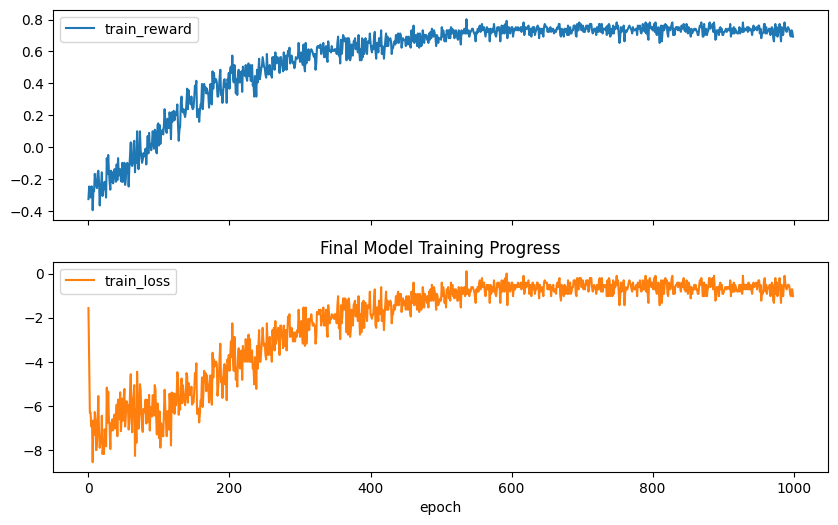

In [9]:
# Save model
model_dir = trainer.logger.log_dir
trainer.save_checkpoint(os.path.join(model_dir, "final_model.ckpt"))
print(f"Final model saved to: {os.path.join(model_dir, 'final_model.ckpt')}")

# Plot training logs
logs = pd.read_csv(os.path.join(model_dir, "metrics.csv"))
logs.set_index('epoch', inplace=True)
logs[['train_reward', 'train_loss']].plot(subplots=True, figsize=(10, 6))
plt.title("Final Model Training Progress")
plt.show()